In [1]:
from gerrychain import Graph
import math
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import geopandas as gpd
from number_of_districts import congressional_districts_2020
filepath = '..\\districting-data-2020\\'
deviation = 0.01   # 1% deviation, i.e., +/- 0.5%

In [2]:
def single_district_polsby_popper(G, L, U):
    
    # create model 
    m = gp.Model()

    # create variables
    # x[i] equals one when vertex i is selected
    x = m.addVars(G.nodes, vtype=GRB.BINARY)  

    # y[u,v] equals one when arc (u,v) is cut because u but not v is selected
    DG = nx.DiGraph(G)   # directed version of G
    y = m.addVars(DG.edges, vtype=GRB.BINARY) 

    # z is inverse Polsby-Popper score for the district 
    z = m.addVar()

    # A = area of district 
    A = m.addVar()

    # P = perimeter of district 
    P = m.addVar()
    
    # objective is to minimize the inverse Polsby-Popper score
    m.setObjective( z, GRB.MINIMIZE )
    
    # add SOCP constraints relating inverse Polsby-Popper score z to area and perimeter
    m.addConstr( P * P <= 4 * math.pi * A * z )

    # add constraint on area A 
    m.addConstr( A == gp.quicksum( G.nodes[i]['area'] * x[i] for i in G.nodes ) )

    # add constraint on perimeter P
    m.addConstr( P == gp.quicksum( DG.edges[u,v]['shared_perim'] * y[u,v] for u,v in DG.edges )
                 + gp.quicksum( G.nodes[i]['boundary_perim'] * x[i] for i in G.nodes if G.nodes[i]['boundary_node'] ) )

    # add constraints saying that district has population at least L and at most U
    m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) >= L )
    m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) <= U )

    # add constraints saying that arc (u,v) is cut if u but not v is selected
    m.addConstrs( x[u] - x[v] <= y[u,v] for u,v in DG.edges )
    
    # solve IP model
    m.Params.TimeLimit = 600
    m.optimize()
    
    print("The inverse PP score is",m.objVal)
    print("The PP score is",1.0/m.objVal)

    # retrieve the districts and their populations
    district = [ i for i in G.nodes if x[i].x > 0.5 ] 
    
    return ( district, 1.0/m.objVal )

In [3]:
def draw_district(G, district, state, level):
    
    # Read shapefile from "<state>_<level>.shp"
    filename = state + '_' + level + '.shp'

    # Read geopandas dataframe from file
    df = gpd.read_file( filepath + filename )
    
    # Which district is each vertex assigned to?
    assignment = [ -1 for i in G.nodes ]
    labeling = { i : 0 for i in G.nodes }
    for i in district:
        labeling[i] = 1

    # Now add the assignments to a column of the dataframe and map it
    node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

    # pick a position u in the dataframe
    for u in range(G.number_of_nodes()):

        geoid = df['GEOID20'][u]

        # what node in G has this geoid?
        i = node_with_this_geoid[geoid]

        # position u in the dataframe should be given
        # the same district # that county i has in 'labeling'
        assignment[u] = labeling[i]

    # now add the assignments to a column of our dataframe and then map it
    df['assignment'] = assignment

    my_fig = df.plot(column='assignment').get_figure()
    return

Using L = 892374 and U = 901342 and k = 2
Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 254 rows, 308 columns and 1196 nonzeros
Model fingerprint: 0x43949823
Model has 1 quadratic constraint
Variable types: 3 continuous, 305 integer (305 binary)
Coefficient statistics:
  Matrix range     [3e-04, 2e+05]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+05, 9e+05]
Presolve time: 0.00s
Presolved: 254 rows, 308 columns, 1196 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 305 integer (305 binary)

Root relaxation: objective 0.000000e+00, 73 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |   


Cutting planes:
  Gomory: 1
  Cover: 2
  Clique: 1
  RLT: 8

Explored 449 nodes (16498 simplex iterations) in 0.48 seconds (0.34 work units)
Thread count was 8 (of 8 available processors)

Solution count 8: 1.59552 1.6292 1.83233 ... 15.9155

Optimal solution found (tolerance 1.00e-04)
Best objective 1.595522137900e+00, best bound 1.595522137900e+00, gap 0.0000%
The inverse PP score is 1.5955221378999083
The PP score is 0.6267540739461259
Using L = 539402 and U = 544823 and k = 2
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 280 rows, 335 columns and 1301 nonzeros
Model fingerprint: 0x51172a0e
Model has 1 quadratic constraint
Variable types: 3 continuous, 332 integer (332 binary)
Coefficient statistics:
  Matrix range     [2e-03, 2e+05]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS 

     0     0    2.37065    0   35    2.55445    2.37065  7.20%     -    0s
     0     0    2.44890    0   31    2.55445    2.44890  4.13%     -    0s
     0     0    2.44890    0   31    2.55445    2.44890  4.13%     -    0s
     0     2    2.44890    0   31    2.55445    2.44890  4.13%     -    0s

Cutting planes:
  Gomory: 2
  MIR: 5
  StrongCG: 2
  RLT: 3

Explored 19 nodes (466 simplex iterations) in 0.12 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 2.55445 5.48955 5.91786 ... 11.9324

Optimal solution found (tolerance 1.00e-04)
Best objective 2.554448233282e+00, best bound 2.554448233282e+00, gap 0.0000%
The inverse PP score is 2.5544482332820673
The PP score is 0.39147397350666063
Using L = 730798 and U = 738142 and k = 4
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 530 rows, 634 columns and

The inverse PP score is 1.5493827794892268
The PP score is 0.6454183002664212
Using L = 914956 and U = 924150 and k = 2
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 208 rows, 251 columns and 975 nonzeros
Model fingerprint: 0xa72cac90
Model has 1 quadratic constraint
Variable types: 3 continuous, 248 integer (248 binary)
Coefficient statistics:
  Matrix range     [3e-02, 5e+05]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+05, 9e+05]
Presolve time: 0.00s
Presolved: 208 rows, 251 columns, 975 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 248 integer (248 binary)

Root relaxation: objective 0.000000e+00, 45 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

H    0     0                       4.9821035    0.42320  91.5%     -    0s
H    0     0                       4.2703623    0.42320  90.1%     -    0s
     0     0    0.60542    0   78    4.27036    0.60542  85.8%     -    0s
     0     0    0.60542    0   80    4.27036    0.60542  85.8%     -    0s
     0     0    1.25862    0   83    4.27036    1.25862  70.5%     -    0s
     0     0    1.25862    0   83    4.27036    1.25862  70.5%     -    0s
     0     2    1.25862    0   83    4.27036    1.25862  70.5%     -    0s
H   34    39                       4.2491221    1.25862  70.4%  48.1    0s
H  311   249                       2.8928095    1.25862  56.5%  21.6    0s
*  311   249              44       2.8928095    1.25862  56.5%  21.7    0s
H  485   219                       2.4152047    1.25862  47.9%  26.1    0s
*  485   219              22       2.4152047    1.25862  47.9%  26.2    0s
H  615   185                       2.3359656    1.25862  46.1%  26.0    0s
*  615   185             

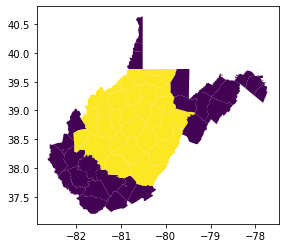

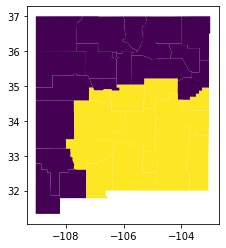

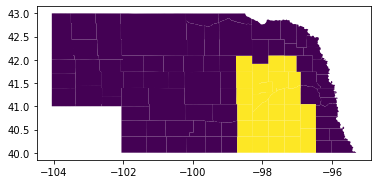

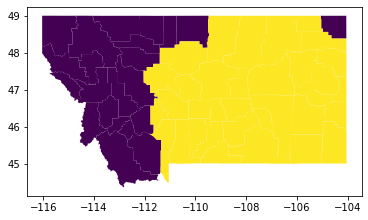

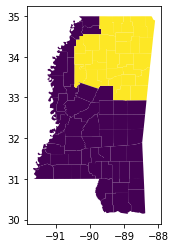

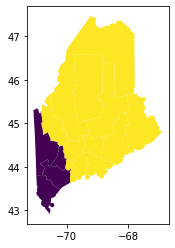

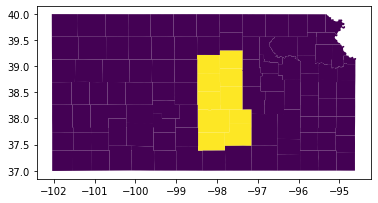

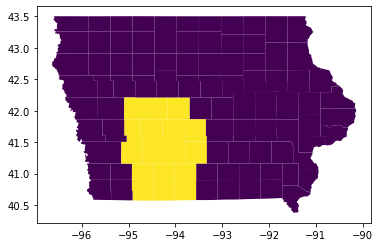

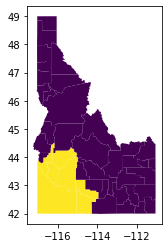

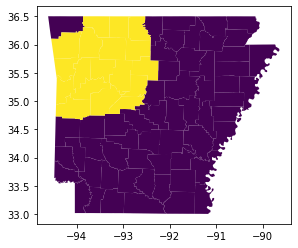

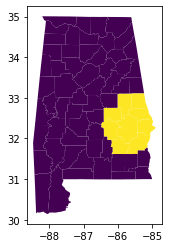

In [4]:
states = ['AL','AR','ID','IA','KS','ME','MS','MT','NE','NM','WV']
level = 'county'
pp_score_county = dict()

for state in reversed(states):
    
    # read graph
    filename = state + '_' + level + '.json'
    G = Graph.from_json( filepath + filename )
    for node in G.nodes:
        G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']
        
    # set parameters
    k = congressional_districts_2020[state]
    total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )
    L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
    U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
    print("Using L =",L,"and U =",U,"and k =",k)
    
    # solve and draw
    (district, pp_score_county[state]) = single_district_polsby_popper(G, L, U)
    draw_district(G, district, state, level)

In [5]:
for state in states:
    print("(County) Polsby-Popper score for",state,"is",pp_score_county[state])

(County) Polsby-Popper score for AL is 0.4797544542575743
(County) Polsby-Popper score for AR is 0.48775528572451576
(County) Polsby-Popper score for ID is 0.4176365748749002
(County) Polsby-Popper score for IA is 0.6454183002664212
(County) Polsby-Popper score for KS is 0.6426561700489477
(County) Polsby-Popper score for ME is 0.39147397350666063
(County) Polsby-Popper score for MS is 0.5803047107169539
(County) Polsby-Popper score for MT is 0.4990189939514949
(County) Polsby-Popper score for NE is 0.6267540739461259
(County) Polsby-Popper score for NM is 0.515369177142556
(County) Polsby-Popper score for WV is 0.4000308179518945


Using L = 539402 and U = 544823 and k = 2
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1684 rows, 2002 columns and 7727 nonzeros
Model fingerprint: 0x3c968ea9
Model has 1 quadratic constraint
Variable types: 3 continuous, 1999 integer (1999 binary)
Coefficient statistics:
  Matrix range     [4e-05, 9e+03]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+05, 5e+05]
Presolve time: 0.01s
Presolved: 1684 rows, 2002 columns, 7727 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 1999 integer (1999 binary)

Root relaxation: objective 0.000000e+00, 512 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Tim

     0     0    0.00000    0    6          -    0.00000      -     -    0s
H    0     0                      80.9926496    0.00000   100%     -    0s
     0     0    0.37592    0  392   80.99265    0.37592   100%     -    0s
H    0     0                      14.8094037    0.37592  97.5%     -    0s
H    0     0                      14.7691654    0.37592  97.5%     -    0s
     0     0    0.84034    0  446   14.76917    0.84034  94.3%     -    0s
H    0     0                      14.6978581    0.84034  94.3%     -    0s
H    0     0                      13.8681030    0.84034  93.9%     -    0s
H    0     0                      13.5287727    0.84034  93.8%     -    0s
     0     0    1.12838    0  446   13.52877    1.12838  91.7%     -    0s
     0     0    1.17867    0  446   13.52877    1.17867  91.3%     -    0s
H    0     0                       2.4952235    1.17867  52.8%     -    0s
     0     0    1.20355    0  446    2.49522    1.20355  51.8%     -    0s
H    0     0             

C:\Users\buchanan\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:239: UserWarning: Found islands (degree-0 nodes). Indices of islands: {214}
  "Found islands (degree-0 nodes). Indices of islands: {}".format(islands)


*    0     0               0      49.5056348    0.57146  98.8%     -    0s
H    0     0                       2.4377604    0.57146  76.6%     -    0s
H    0     0                       2.1970163    0.57146  74.0%     -    0s
H    0     0                       1.9693168    0.72615  63.1%     -    0s
     0     0    0.72615    0  389    1.96932    0.72615  63.1%     -    0s
     0     0    0.96532    0  363    1.96932    0.96532  51.0%     -    0s
     0     0    1.01567    0  389    1.96932    1.01567  48.4%     -    0s
     0     0    1.02953    0  389    1.96932    1.02953  47.7%     -    0s
     0     0    1.03540    0  389    1.96932    1.03540  47.4%     -    0s
     0     0    1.11009    0  389    1.96932    1.11009  43.6%     -    0s
     0     0    1.11009    0  389    1.96932    1.11009  43.6%     -    0s
     0     0    1.39676    0  389    1.96932    1.39676  29.1%     -    1s
     0     0    1.39676    0  389    1.96932    1.39676  29.1%     -    1s
     0     2    1.39676  


Optimal solution found (tolerance 1.00e-04)
Best objective 2.036499574199e+00, best bound 2.036499574199e+00, gap 0.0000%
The inverse PP score is 2.0364995741985163
The PP score is 0.4910386491946896
Using L = 650566 and U = 657103 and k = 3
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2844 rows, 3396 columns and 13090 nonzeros
Model fingerprint: 0xb690df8c
Model has 1 quadratic constraint
Variable types: 3 continuous, 3393 integer (3393 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+05, 7e+05]
Presolve time: 0.01s
Presolved: 2844 rows, 3396 columns, 13090 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 3393 integer (3393 binary)

Root relaxation: objective 0.00000

   889    92     cutoff   19         1.60459    1.07335  33.1%   249   20s
H  917    83                       1.5325033    1.07335  30.0%   250   20s
H  996    86                       1.5277147    1.07335  29.7%   236   20s
H 1014    86                       1.5272610    1.07335  29.7%   232   20s
* 1028    86              24       1.5263936    1.07335  29.7%   230   20s
H 1122     8                       1.5241815    1.52396  0.01%   216   20s
* 1122     8              22       1.5241815    1.52396  0.01%   217   20s

Cutting planes:
  Gomory: 5

Explored 1149 nodes (249585 simplex iterations) in 20.76 seconds (27.33 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 1.52418 1.52639 1.52726 ... 1.62331

Optimal solution found (tolerance 1.00e-04)
Best objective 1.524181482787e+00, best bound 1.524180272235e+00, gap 0.0001%
The inverse PP score is 1.5241814827873448
The PP score is 0.6560898497279021
Using L = 730798 and U = 738142 and k = 4
Set parameter T

H    0     0                      11.8030842    0.57798  95.1%     -    2s
     0     2    0.57798    0  835   11.80308    0.57798  95.1%     -    3s
H   27    32                       8.3451367    0.61632  92.6%   390    3s
H   29    32                       7.5863160    0.62485  91.8%   367    3s
H   60    66                       5.5039382    0.62591  88.6%   350    4s
H   64    66                       5.4095549    0.62591  88.4%   347    4s
H  132   134                       5.3324868    0.62591  88.3%   253    4s
   174   186    1.59161   27  261    5.33249    0.62591  88.3%   224    5s
H  198   209                       4.6497929    0.62591  86.5%   223    5s
H  202   209                       2.4796156    0.62591  74.8%   221    5s
H  236   224                       1.5870006    0.62591  60.6%   211    5s
   375   120    0.99433    6  836    1.58700    0.88484  44.2%   223   11s
   380   123    1.38933   24  852    1.58700    0.88484  44.2%   220   15s
H  381   117             

H    0     0                       4.8682351    0.00000   100%     -    0s
H    0     0                       4.8645990    0.00000   100%     -    0s
H    0     0                       4.4522850    0.00000   100%     -    0s
H    0     0                       4.3626824    0.11615  97.3%     -    0s
     0     0    0.11615    0  859    4.36268    0.11615  97.3%     -    0s
H    0     0                       4.1464852    0.11615  97.2%     -    0s
     0     0    0.11825    0  859    4.14649    0.11825  97.1%     -    1s
H    0     0                       4.1251896    0.11825  97.1%     -    1s
     0     0    0.12024    0  859    4.12519    0.12024  97.1%     -    1s
     0     0    0.12061    0  859    4.12519    0.12061  97.1%     -    1s
H    0     0                       2.2244405    0.12061  94.6%     -    2s
     0     0    0.12081    0  859    2.22444    0.12081  94.6%     -    2s
H    0     0                       2.2244405    0.12081  94.6%     -    2s
     0     0    0.12088  

Using L = 813815 and U = 821993 and k = 4
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3904 rows, 4619 columns and 17773 nonzeros
Model fingerprint: 0x32272959
Model has 1 quadratic constraint
Variable types: 3 continuous, 4616 integer (4616 binary)
Coefficient statistics:
  Matrix range     [5e-05, 2e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+05, 8e+05]
Presolve time: 0.01s
Presolved: 3904 rows, 4619 columns, 17773 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 4616 integer (4616 binary)

Root relaxation: objective 0.000000e+00, 820 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node T

* 1056   221              26       1.5439949    1.05587  31.6%   364   45s
H 1168   210                       1.5036000    1.08771  27.7%   360   48s
* 1168   210              27       1.5036000    1.08771  27.7%   360   48s
* 1222   209              28       1.5008626    1.10074  26.7%   358   50s
H 1441   211                       1.4839294    1.21203  18.3%   353   53s
* 1441   211              46       1.4839294    1.21203  18.3%   353   53s
* 1467   186              46       1.4839247    1.21994  17.8%   347   54s
  1520   166     cutoff   24         1.48392    1.24706  16.0%   348   55s
H 1668   113                       1.4636489    1.35395  7.49%   346   57s
H 1711   114                       1.4444416    1.40360  2.83%   343   57s
* 1711   114              25       1.4444416    1.40360  2.83%   344   57s
* 1776     0              25       1.4444415    1.41362  2.13%   333   57s

Cutting planes:
  Gomory: 18

Explored 1836 nodes (601366 simplex iterations) in 57.83 seconds (109

  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+05, 7e+05]
Presolve time: 0.02s
Presolved: 5544 rows, 6544 columns, 25211 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 6541 integer (6541 binary)

Root relaxation: objective 0.000000e+00, 843 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    8          -    0.00000      -     -    0s
H    0     0                      48.7470158    0.00000   100%     -    0s
     0     0    0.00000    0  163   48.74702    0.00000   100%     -    0s
H    0     0                       3.2750084    0.00000   100%     -    0s
H    0     0                       3.2106939    0.00000   100%     -    0s
     0     0    0.16022    0 1060    3.21069    0.16022  95.0%     -    1

H    0     0                      36.4375580    0.21197  99.4%     -    1s
H    0     0                      31.3098481    0.35615  98.9%     -    2s
H    0     0                      30.4452910    0.35615  98.8%     -    2s
     0     0    0.35644    0 1466   30.44529    0.35644  98.8%     -    2s
H    0     0                      14.3673358    0.35644  97.5%     -    2s
     0     0    0.35647    0 1467   14.36734    0.35647  97.5%     -    2s
     0     0    0.41890    0 1467   14.36734    0.41890  97.1%     -    3s
H    0     0                      14.0088087    0.41890  97.0%     -    3s
     0     0    0.44502    0 1466   14.00881    0.44502  96.8%     -    3s
H    0     0                      13.1460679    0.44502  96.6%     -    3s
     0     0    0.44715    0 1466   13.14607    0.44715  96.6%     -    3s
H    0     0                      12.8033340    0.44715  96.5%     -    3s
     0     0    0.44834    0 1466   12.80333    0.44834  96.5%     -    4s
H    0     0             

H 1020   528                       1.8145907    0.61923  65.9%   449   59s
  1036   545    1.38423   43 1356    1.81459    0.63502  65.0%   452   60s
  1172   560 infeasible   33         1.81459    0.63502  65.0%   452   65s
H 1241   523                       1.7612341    0.67960  61.4%   444   67s
H 1263   529                       1.7612341    0.67960  61.4%   446   68s
* 1263   529              97       1.7612341    0.67960  61.4%   446   68s
  1327   531    1.49986   29  856    1.76123    0.67960  61.4%   443   71s
  1438   556    1.75854   19 1292    1.76123    0.72221  59.0%   446   75s
H 1444   511                       1.7280549    0.72221  58.2%   447   75s
* 1444   511              40       1.7280549    0.72221  58.2%   447   75s
* 1475   492              40       1.7280547    0.72221  58.2%   449   77s
H 1502   466                       1.7277199    0.72221  58.2%   442   77s
* 1529   472              74       1.7277199    0.74873  56.7%   446   79s
  1545   478    1.14428  

C:\Users\buchanan\Anaconda3\lib\site-packages\geopandas\plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


Using L = 727548 and U = 734859 and k = 7
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 7358 rows, 8680 columns and 33455 nonzeros
Model fingerprint: 0xd09244b8
Model has 1 quadratic constraint
Variable types: 3 continuous, 8677 integer (8677 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+05, 7e+05]
Presolve time: 0.03s
Presolved: 7358 rows, 8680 columns, 33455 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 8677 integer (8677 binary)

Root relaxation: objective 0.000000e+00, 1016 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node 

    11    16    0.19089    4  665   11.78838    0.18116  98.5%  1235   10s
H   18    20                       1.6268185    0.18116  88.9%  1137   10s
H   27    29                       1.6199584    0.18116  88.8%  1067   11s
    84    84    0.27830   16 1218    1.61996    0.18116  88.8%   722   15s
   171   166    0.44280   40  908    1.61996    0.18116  88.8%   649   20s
   334   324    0.76160   71  442    1.61996    0.18116  88.8%   462   25s
H  397   381                       1.6137146    0.18116  88.8%   430   26s
H  507   452                       1.4546531    0.18116  87.5%   370   28s
H  596   525                       1.4051919    0.18116  87.1%   331   28s
H  618   635                       1.4051919    0.18116  87.1%   320   29s
   828   760    0.86539  221  325    1.40519    0.18116  87.1%   258   30s
   951   834    1.20950  137 1520    1.40519    0.18116  87.1%   266   35s
   954   836    0.96087  228 1520    1.40519    0.18116  87.1%   265   40s
   970   844    0.57901  

     0     2    0.06946    0 1447    3.51451    0.06946  98.0%     -    3s
     7    12    0.12417    3  596    3.51451    0.12329  96.5%  1624    5s
H   45    50                       3.0514021    0.12443  95.9%  1053    8s
H   64    75                       2.7347848    0.12443  95.5%   961    9s
    84    94    0.16864   16 1576    2.73478    0.12443  95.5%   787   10s
   204   225    0.57824   51   71    2.73478    0.12443  95.5%   527   15s
H  224   233                       1.8032935    0.12443  93.1%   506   15s
H  263   230                       1.6662138    0.12443  92.5%   473   16s
H  310   256                       1.6662138    0.12443  92.5%   430   17s
H  563   512                       1.5402434    0.12443  91.9%   289   19s
*  563   512              43       1.5402434    0.12443  91.9%   289   19s
   612   543    0.64171  251  181    1.54024    0.12443  91.9%   288   20s
   914   806    1.04651   94 1447    1.54024    0.12443  91.9%   241   26s
   917   808    0.75288  

  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+05, 7e+05]
Presolve time: 0.03s
Presolved: 8510 rows, 10051 columns, 38720 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 10048 integer (10048 binary)

Root relaxation: objective 0.000000e+00, 1028 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    5          -    0.00000      -     -    0s
H    0     0                     130.8379125    0.00000   100%     -    0s
     0     0    0.00000    0  906  130.83791    0.00000   100%     -    1s
H    0     0                      41.8928593    0.00000   100%     -    1s
H    0     0                      39.2743742    0.00000   100%     -    1s
     0     0    0.19295    0 1543   39.27437    0.19295   100%     - 

Coefficient statistics:
  Matrix range     [2e-05, 9e+03]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+05, 8e+05]
Presolve time: 0.04s
Presolved: 8980 rows, 10633 columns, 41018 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 10630 integer (10630 binary)

Root relaxation: objective 0.000000e+00, 1036 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                     167.5211583    0.00000   100%     -    0s
*    0     0               0     167.5211583    0.00000   100%     -    0s
H    0     0                      64.1322559    0.00000   100%     -    0s
H    0     0                      61.1803575    0.00000   100%     -    0s
H    0     0                      57.3599471    0.19797   100%     -    3s
     0     

Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 9461 integer (9461 binary)

Root relaxation: objective 0.000000e+00, 902 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    7          -    0.00000      -     -    0s
H    0     0                     131.8532181    0.00000   100%     -    0s
H    0     0                     131.7824103    0.24382   100%     -    2s
H    0     0                     131.7810812    0.24382   100%     -    2s
H    0     0                      86.5680923    0.24382   100%     -    2s
H    0     0                      82.3702921    0.24382   100%     -    2s
     0     0    0.24382    0 1315   82.37029    0.24382   100%     -    2s
H    0     0                      11.6141471    0.24382  97.9%     -    2s
H    0     0                      10.4461115    0.24574 

   569   433    0.59858   32 1235    1.46217    0.40043  72.6%   777  100s
   647   482    0.84823   40  924    1.46217    0.40043  72.6%   739  106s
   729   500    0.92508   48 1355    1.46217    0.40043  72.6%   697  111s
   805   518    0.82352   57  926    1.46217    0.40043  72.6%   672  116s
   906   572    0.92798   71 1006    1.46217    0.40043  72.6%   636  121s
  1003   579    1.32459   82 1070    1.46217    0.40043  72.6%   600  126s
  1068   587    1.43371   98  721    1.46217    0.40043  72.6%   588  131s
  1128   605    0.53760   27 1360    1.46217    0.40043  72.6%   586  136s
  1185   635    0.73729   44 1854    1.46217    0.40043  72.6%   582  142s
  1280   735    1.31145   99  578    1.46217    0.40043  72.6%   565  147s
H 1292   694                       1.4345260    0.40043  72.1%   560  147s
  1417   721    1.09464   23  924    1.43453    0.49018  65.8%   539  152s
  1451   767    0.91049   26 1494    1.43453    0.49018  65.8%   538  155s
  1574   849    1.32768  

H   65    68                       1.9155821    0.19762  89.7%   707    9s
H   80    80                       1.9139892    0.19762  89.7%   657    9s
*   80    80              16       1.9139892    0.19762  89.7%   659    9s
    89    95    0.65986   16  453    1.91399    0.19762  89.7%   626   10s
*   99    95              16       1.9139892    0.19762  89.7%   582   10s
   196   182    0.98571   51  647    1.91399    0.19762  89.7%   544   15s
H  202   182                       1.8643785    0.19762  89.4%   531   15s
H  238   211                       1.7104554    0.19762  88.4%   503   16s
H  246   226                       1.7058964    0.19762  88.4%   499   16s
   385   294    0.99634  152 1438    1.70590    0.19762  88.4%   392   21s
   387   295    1.28181   36 1591    1.70590    0.19762  88.4%   390   25s
   389   297    0.81071   25 1592    1.70590    0.32760  80.8%   388   30s
   393   299    1.61617   17 1604    1.70590    0.34774  79.6%   384   36s
   396   301    0.63195  

   698   407    1.62352   49 1297    1.62920    0.57405  64.8%   511   70s
   812   417 infeasible   61         1.62920    0.57405  64.8%   503   76s
   915   411    0.68322   19 1078    1.62920    0.61042  62.5%   495   80s
  1033   481 infeasible   39         1.62920    0.61042  62.5%   482   86s
  1154   489    1.35922   23  947    1.62920    0.68327  58.1%   476   91s
  1234   548    1.20391   25 1213    1.62920    0.72658  55.4%   493   96s
  1320   587    0.93431   26 1409    1.62920    0.72748  55.3%   494  101s
  1403   638    1.36477   46  728    1.62920    0.73171  55.1%   493  105s
  1487   675    1.50486   41 1597    1.62920    0.73477  54.9%   500  110s
  1569   736    1.32888   52 1587    1.62920    0.73792  54.7%   505  115s
  1674   783    1.02240   21 1250    1.62920    0.73829  54.7%   508  121s
  1787   847    1.56906   28 1208    1.62920    0.73829  54.7%   511  126s
  1910   884    1.36093   22  745    1.62920    0.74598  54.2%   513  132s
  1967   921    1.28374  

   379   277    1.23235    8 1741    1.36311    0.14646  89.3%   507   32s
   381   278    0.14646    6 1853    1.36311    0.14646  89.3%   505   36s
   384   280    0.49906   31 1853    1.36311    0.14646  89.3%   501   41s
   388   286    0.14646   13 1858    1.36311    0.14646  89.3%   536   45s
   398   293    1.05841   15 1775    1.36311    0.14646  89.3%   603   52s
   410   296    0.16074   17 1630    1.36311    0.16074  88.2%   647   55s
   461   299    0.23423   23 1564    1.36311    0.17114  87.4%   655   60s
   524   321    0.45641   32  822    1.36311    0.17114  87.4%   654   65s
   593   371    0.38008   43 1592    1.36311    0.17114  87.4%   634   70s
H  736   413                       1.3592970    0.17114  87.4%   575   74s
   753   445    0.80896   62  375    1.35930    0.17114  87.4%   567   75s
H  882   488                       1.3439390    0.17114  87.3%   520   77s
   942   486    0.89633   85  449    1.34394    0.17114  87.3%   506   80s
  1051   516    0.28318  

H    0     0                       3.1064299    0.15317  95.1%     -    7s
     0     0    0.15320    0 1898    3.10643    0.15320  95.1%     -    7s
     0     0    0.15321    0 1898    3.10643    0.15321  95.1%     -    8s
     0     0    0.15322    0 1898    3.10643    0.15322  95.1%     -    8s
     0     0    0.15322    0 1898    3.10643    0.15322  95.1%     -    8s
     0     2    0.15459    0 1898    3.10643    0.15459  95.0%     -    9s
     3     8    0.15597    2  620    3.10643    0.15459  95.0%  1173   10s
    19    24    1.10361    4  897    3.10643    0.17850  94.3%  2717   16s
    34    42    0.24348    9 1556    3.10643    0.17888  94.2%  2323   20s
H   63    66                       1.6548517    0.17888  89.2%  1545   22s
H   75    70                       1.6309747    0.17888  89.0%  1396   23s
*   75    70              11       1.6309747    0.17888  89.0%  1413   23s
    87    88    0.35161   24 1579    1.63097    0.17888  89.0%  1338   25s
H  191   170             

  3296  2298    1.24655   26 2189    1.56117    0.43132  72.4%   206  122s
  3342  2327    0.59607   29 2246    1.56117    0.43132  72.4%   207  125s
  3446  2396    0.75265   39 2068    1.56117    0.43132  72.4%   210  130s
  3570  2471    0.91822   48 1903    1.56117    0.43132  72.4%   212  136s
  3711  2503    1.02217   66 1811    1.56117    0.43132  72.4%   214  142s
  3780  2514    1.11837   76 1082    1.56117    0.43132  72.4%   216  145s
  3909  2521    0.59073   28 2240    1.56117    0.47029  69.9%   220  152s
  3953  2560 infeasible   41         1.56117    0.48369  69.0%   223  156s
  4108  2686    0.98597   62 1090    1.56117    0.48369  69.0%   224  163s
  4213  2714    1.36460   94 1380    1.56117    0.48676  68.8%   224  167s
  4318  2717    1.47724   35 1923    1.56117    0.49443  68.3%   224  171s
  4376  2733 infeasible   40         1.56117    0.49443  68.3%   228  175s
  4445  2787    1.12036   47 1513    1.56117    0.49443  68.3%   232  180s
  4666  2878    1.03546  

*  471   227              25       1.6421952    0.33786  79.4%   864   89s
   476   229    0.33997   22 1650    1.64220    0.33789  79.4%   857   91s
   494   236    0.34369   24 2246    1.64220    0.34194  79.2%   882   95s
   523   250    0.92132   26 2134    1.64220    0.39378  76.0%   883  100s
   561   235    0.96720   29 2330    1.64220    0.39378  76.0%   881  105s
   585   238    1.40196   32 1504    1.64220    0.39378  76.0%   911  111s
   623   251    0.60551   40 1041    1.64220    0.39378  76.0%   908  115s
   672   261    0.78392   49  929    1.64220    0.39378  76.0%   900  121s
   729   299    0.96648   59 1993    1.64220    0.39378  76.0%   877  126s
   797   329    1.16291   66 1772    1.64220    0.39378  76.0%   837  130s
   931   409    1.48063   75  565    1.64220    0.39378  76.0%   757  135s
  1108   535    1.56921   94  742    1.64220    0.39378  76.0%   666  141s
H 1135   445                       1.5921229    0.39378  75.3%   660  141s
  1209   446    0.52951  

     0     2    0.09512    0 3005    3.03120    0.09512  96.9%     -   22s
     3     8    0.09677    2 1158    3.03120    0.09635  96.8%  1494   26s
     7    12    0.10322    3 3022    3.03120    0.09683  96.8%  2001   31s
    15    20    0.10373    4 2990    3.03120    0.10373  96.6%  2920   35s
H   29    34                       2.9858901    0.10382  96.5%  1994   39s
H   31    34                       1.9824071    0.10382  94.8%  1915   39s
    33    40    0.81268    8 1954    1.98241    0.10382  94.8%  2123   44s
    39    45    0.11816    9 2783    1.98241    0.10382  94.8%  2009   48s
    44    50    0.41960    9 2538    1.98241    0.10382  94.8%  2301   52s
    55    61    0.29681   10 2938    1.98241    0.10382  94.8%  2076   56s
    79    89    0.13576   16 2758    1.98241    0.10382  94.8%  1716   61s
    88   102    0.32978   17 3172    1.98241    0.10382  94.8%  1628   67s
   117   138    0.16326   23 2849    1.98241    0.10382  94.8%  1403   70s
   173   190    0.82293  


Solution count 10: 1.42712 1.43863 1.46037 ... 1.93679

Time limit reached
Best objective 1.427120062301e+00, best bound 3.893985910943e-01, gap 72.7144%
The inverse PP score is 1.4271200623006886
The PP score is 0.7007118927246249
Using L = 741943 and U = 749398 and k = 14
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 14848 rows, 17519 columns and 67496 nonzeros
Model fingerprint: 0xdea0c676
Model has 1 quadratic constraint
Variable types: 3 continuous, 17516 integer (17516 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+05, 7e+05]
Presolve time: 0.05s
Presolved: 14848 rows, 17519 columns, 67496 nonzeros
Presolved model has 1

  1799  1134    1.50177   75 1687    1.50573    0.28471  81.1%   625  383s
  1836  1157    0.88515   80 2567    1.50573    0.28471  81.1%   625  392s
  1879  1167    0.90432   84 2257    1.50573    0.28471  81.1%   624  399s
  1915  1178    1.14505   87 1652    1.50573    0.28471  81.1%   625  407s
  1958  1196    1.12193   94 2265    1.50573    0.28471  81.1%   625  416s
  2016  1200    1.29763  102 1315    1.50573    0.28471  81.1%   620  423s
  2066  1204    1.35103  111 1437    1.50573    0.28471  81.1%   616  432s
  2108  1214    1.35494  121  483    1.50573    0.28471  81.1%   619  443s
  2142  1230    1.35605  127    -    1.50573    0.28471  81.1%   623  451s
  2200  1223    1.49482  142  396    1.50573    0.30972  79.4%   621  463s
  2231  1227    0.35037   21 2414    1.50573    0.31049  79.4%   627  472s
  2257  1232    1.32759   26 2272    1.50573    0.31049  79.4%   633  483s
  2283  1246 infeasible   32         1.50573    0.34965  76.8%   640  494s
  2312  1274    0.69312  

  1389   880    0.68189   80 1811    1.53152    0.19048  87.6%   836  287s
  1429   909    0.77551   84 1712    1.53152    0.19048  87.6%   826  291s
  1471   934    0.91871   88 2932    1.53152    0.19048  87.6%   816  295s
  1574   993    0.88153  102 2040    1.53152    0.19048  87.6%   789  304s
  1640  1003    0.94925  110 1357    1.53152    0.19048  87.6%   772  310s
  1698  1037    1.13192  121 1687    1.53152    0.19048  87.6%   759  317s
  1759  1059    1.06429  129 1639    1.53152    0.19048  87.6%   744  322s
  1821  1081    1.45944  137 1679    1.53152    0.19048  87.6%   731  328s
  1874  1115    1.29606  148 1013    1.53152    0.19048  87.6%   723  334s
  1928  1142    1.17796  156 2245    1.53152    0.19048  87.6%   715  341s
  1997  1164    1.25431  169 1918    1.53152    0.19048  87.6%   705  348s
  2068  1180    1.36736  185 1639    1.53152    0.20675  86.5%   694  354s
  2143  1220    0.22658   21 2897    1.53152    0.22658  85.2%   685  361s
  2224  1291    0.24497  

   637   421    0.74246   37 2613    1.38781    0.30621  77.9%  1320  257s
   650   428    0.74362   38 2628    1.38781    0.30944  77.7%  1319  264s
   661   436    0.32525   39 1846    1.38781    0.31283  77.5%  1328  270s
   673   445    0.34110   41 1236    1.38781    0.32526  76.6%  1339  275s
   699   449    0.73471   46 1136    1.38781    0.32526  76.6%  1364  284s
   710   451    0.39923   46 2343    1.38781    0.32526  76.6%  1365  289s
   730   448    0.40276   48 1116    1.38781    0.32526  76.6%  1353  293s
   742   455    0.45840   49 1115    1.38781    0.32526  76.6%  1355  298s
   759   461    0.66466   52 1094    1.38781    0.32526  76.6%  1354  302s
   782   475    0.46507   54 1030    1.38781    0.32526  76.6%  1340  308s
   812   480    0.46806   57 1015    1.38781    0.32526  76.6%  1318  314s
   845   502    0.50498   61  934    1.38781    0.32526  76.6%  1297  319s
   880   526    0.69116   69 1477    1.38781    0.32526  76.6%  1275  326s
   937   551    0.79340  

   564   549    0.36042  109 1253    1.52287    0.08258  94.6%  1048  156s
   609   604    1.14546  118  385    1.52287    0.08258  94.6%  1040  163s
   646   629    0.45916  125 2521    1.52287    0.08258  94.6%  1012  168s
   677   664    0.50586  132  937    1.52287    0.08258  94.6%  1003  172s
   714   717    0.58385  142  574    1.52287    0.08258  94.6%   978  175s
   844   876    0.72890  170  716    1.52287    0.08258  94.6%   881  182s
   930   968    0.74460  191  350    1.52287    0.08258  94.6%   822  186s
  1151  1222    0.76535  278  260    1.52287    0.08258  94.6%   701  192s
  1288  1238    0.79332  334  436    1.52287    0.08258  94.6%   645  196s
  1375  1323    0.88959  367  433    1.52287    0.08258  94.6%   636  204s
  1431  1324    1.37370  418 3329    1.52287    0.08258  94.6%   629  213s
  1433  1325    0.90861   22 3329    1.52287    0.08258  94.6%   628  225s
  1434  1326    1.38667   99 3329    1.52287    0.08258  94.6%   627  230s
  1435  1327    0.41111  

    11    16    0.57661    3 2773    6.34645    0.12745  98.0%  3594   49s
    15    20    0.13717    4 3476    6.34645    0.12805  98.0%  4115   52s
    29    34    0.81371    7 2685    6.34645    0.12805  98.0%  2901   60s
    33    41    0.16437    8 2053    6.34645    0.12805  98.0%  2913   65s
    48    56    0.16616   10 2022    6.34645    0.12805  98.0%  2770   72s
    55    61    0.60071   11 2032    6.34645    0.12805  98.0%  2661   75s
    80    89    0.21244   14 1768    6.34645    0.12805  98.0%  2138   81s
H   92   103                       6.2260648    0.12805  97.9%  1916   83s
   122   139    0.24986   22  342    6.22606    0.12805  97.9%  1570   86s
H  125   139                       5.8138512    0.12805  97.8%  1535   86s
H  128   139                       4.6331891    0.12805  97.2%  1506   86s
H  139   161                       4.1028461    0.12805  96.9%  1442   87s
H  161   181                       3.5164365    0.12805  96.4%  1293   88s
H  163   181             

C:\Users\buchanan\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:239: UserWarning: Found islands (degree-0 nodes). Indices of islands: {2678}
  "Found islands (degree-0 nodes). Indices of islands: {}".format(islands)


Using L = 773087 and U = 780855 and k = 26
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 29688 rows, 35098 columns and 135107 nonzeros
Model fingerprint: 0x99bfdfda
Model has 1 quadratic constraint
Variable types: 3 continuous, 35095 integer (35095 binary)
Coefficient statistics:
  Matrix range     [2e-06, 2e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+05, 8e+05]
Presolve time: 0.13s
Presolved: 29688 rows, 35098 columns, 135107 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 35095 integer (35095 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with primal simplex

Root relaxation: objective 0.000000e+00, 0 iterations, 0.04 seconds (0.04 wor

  2011  1843    0.09106   36 1801    1.42797    0.09106  93.6%   524  593s
  2024  1851    0.13514   37 1409    1.42797    0.09636  93.3%   527  599s
  2038  1847    0.09642   39 1817    1.42797    0.09642  93.2%   530  600s

Explored 2039 nodes (1109212 simplex iterations) in 600.03 seconds (745.73 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 1.42797 1.4746 2.10908 ... 9.53724

Time limit reached
Best objective 1.427974459997e+00, best bound 9.641850786614e-02, gap 93.2479%
The inverse PP score is 1.427974459997442
The PP score is 0.7002926368877713


C:\Users\buchanan\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:239: UserWarning: Found islands (degree-0 nodes). Indices of islands: {1636}
  "Found islands (degree-0 nodes). Indices of islands: {}".format(islands)


Using L = 765375 and U = 773067 and k = 28
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 28198 rows, 33357 columns and 128210 nonzeros
Model fingerprint: 0x20680476
Model has 1 quadratic constraint
Variable types: 3 continuous, 33354 integer (33354 binary)
Coefficient statistics:
  Matrix range     [4e-06, 2e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+05, 8e+05]
Presolve time: 0.14s
Presolved: 28198 rows, 33357 columns, 128210 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 33354 integer (33354 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with primal simplex

Root relaxation: objective 0.000000e+00, 0 iterations, 0.05 seconds (0.04 wor

   999   584    0.49216   70 2347    1.28335    0.26330  79.5%  1307  600s

Cutting planes:
  Gomory: 1

Explored 1036 nodes (1338620 simplex iterations) in 600.12 seconds (880.62 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 1.28335 1.2868 1.29041 ... 1.68014

Time limit reached
Best objective 1.283349522371e+00, best bound 2.632973237841e-01, gap 79.4836%
The inverse PP score is 1.2833495223707703
The PP score is 0.7792109496037134
Using L = 763153 and U = 770821 and k = 38
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 37112 rows, 44007 columns and 169257 nonzeros
Model fingerprint: 0x9be3e2e2
Model has 1 quadratic constraint
Variable types: 3 continuous, 44004 integer (44004 binary)
Coefficient statistics:
  Matrix range     [1e-05,

C:\Users\buchanan\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:239: UserWarning: Found islands (degree-0 nodes). Indices of islands: {1212}
  "Found islands (degree-0 nodes). Indices of islands: {}".format(islands)


Using L = 756549 and U = 764152 and k = 52
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 49956 rows, 59084 columns and 227200 nonzeros
Model fingerprint: 0x626d2a99
Model has 1 quadratic constraint
Variable types: 3 continuous, 59081 integer (59081 binary)
Coefficient statistics:
  Matrix range     [2e-06, 4e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+05, 8e+05]
Presolve time: 0.23s
Presolved: 49956 rows, 59084 columns, 227200 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 59081 integer (59081 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with primal simplex

Root relaxation: objective 0.000000e+00, 0 iterations, 0.10 seconds (0.07 wor

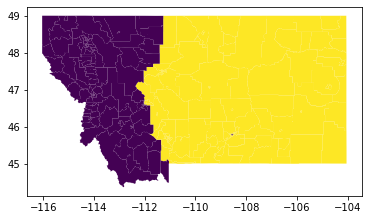

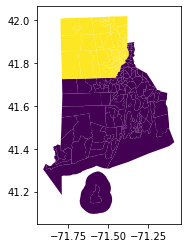

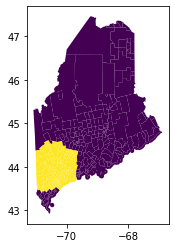

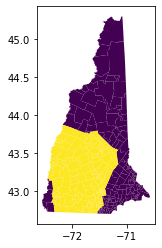

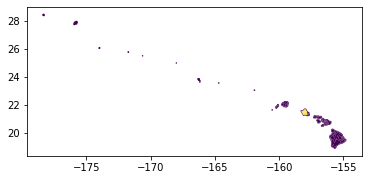

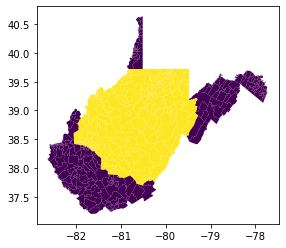

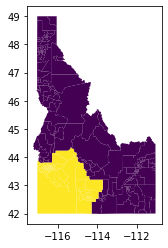

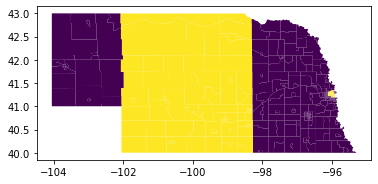

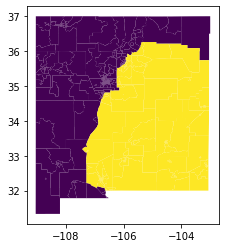

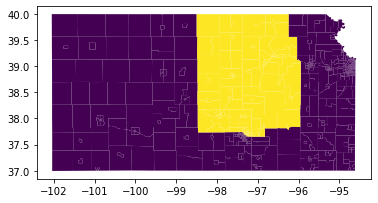

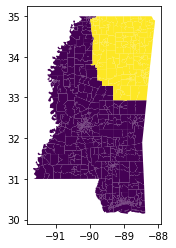

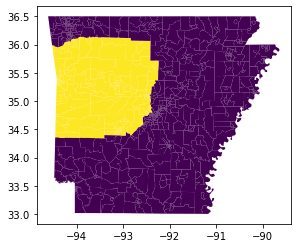

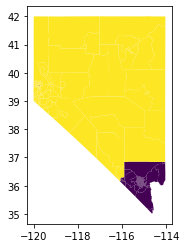

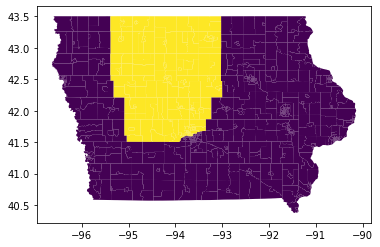

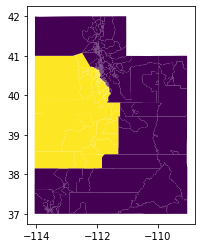

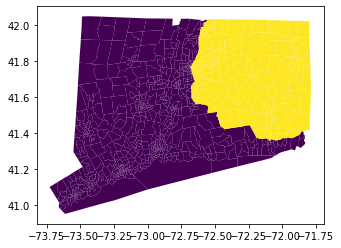

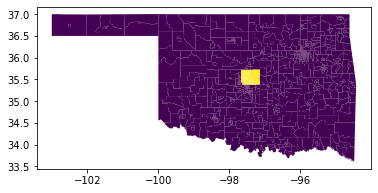

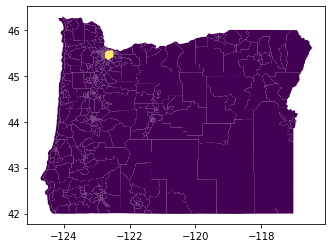

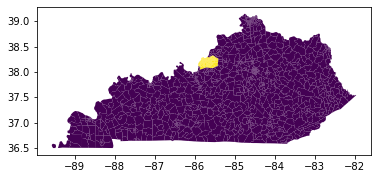

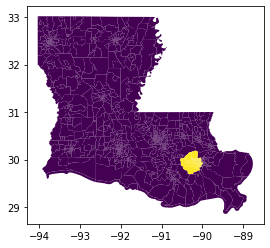

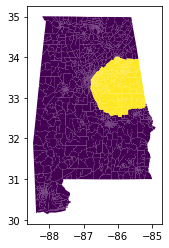

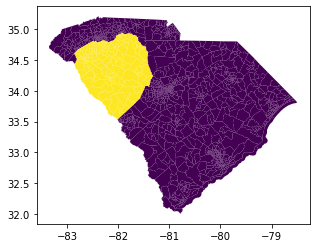

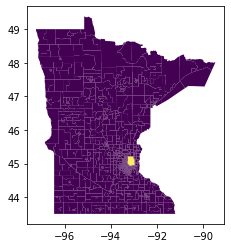

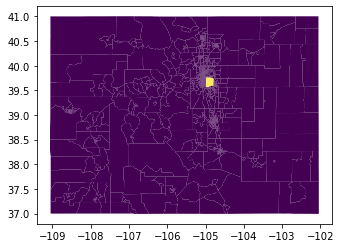

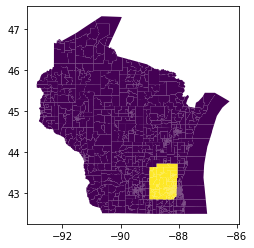

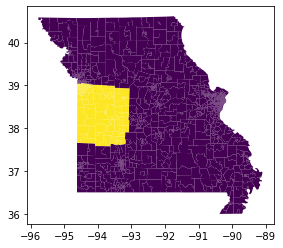

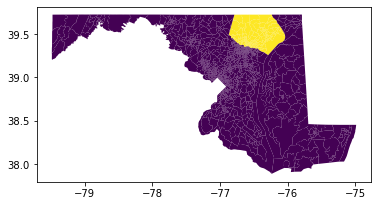

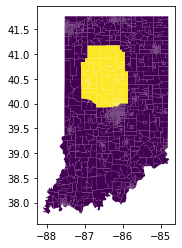

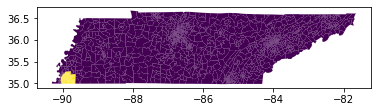

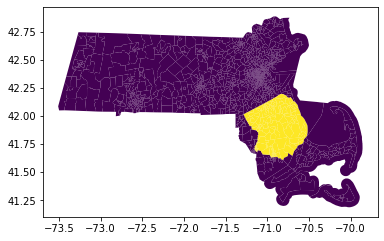

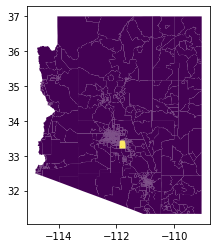

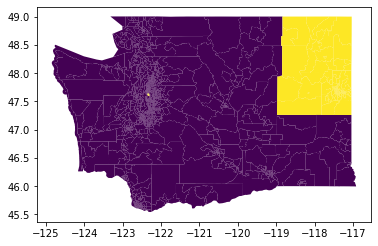

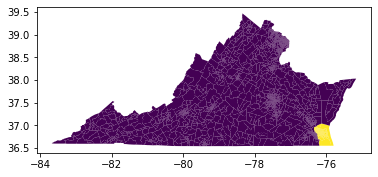

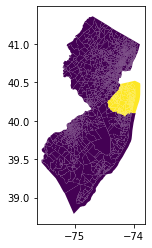

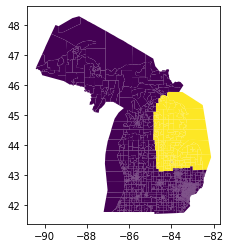

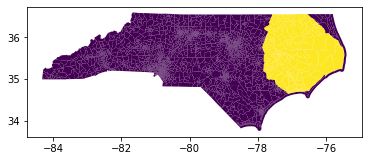

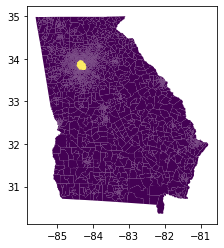

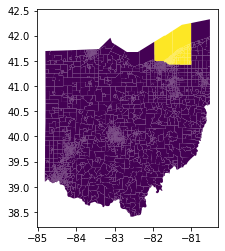

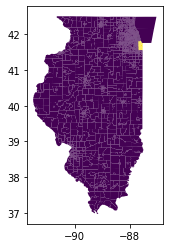

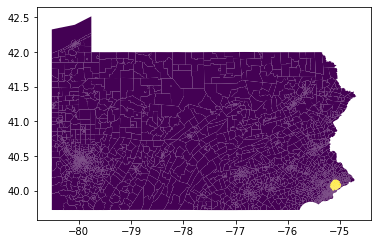

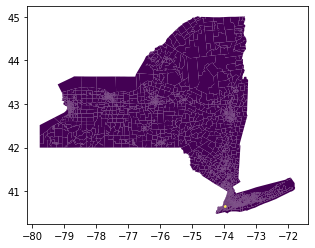

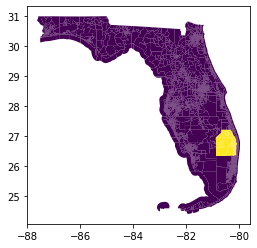

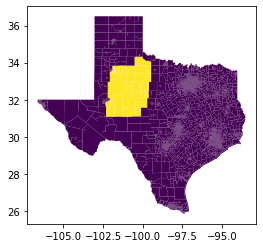

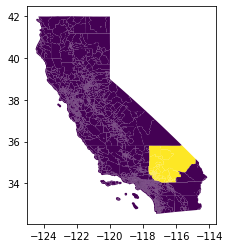

In [6]:
states = [ key for key in congressional_districts_2020.keys() if congressional_districts_2020[key] >= 2 ]
level = 'tract'
pp_score_tract = dict()

for state in reversed(states):
    
    # read graph
    filename = state + '_' + level + '.json'
    G = Graph.from_json( filepath + filename )
    for node in G.nodes:
        G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']
        
    # set parameters
    k = congressional_districts_2020[state]
    total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )
    L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
    U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
    print("Using L =",L,"and U =",U,"and k =",k)
    
    # solve and draw
    (district, pp_score_tract[state]) = single_district_polsby_popper(G, L, U)
    draw_district(G, district, state, level)

In [7]:
for state in states:
    print("(Tract) Polsby-Popper score for",state,"is",pp_score_tract[state])

(Tract) Polsby-Popper score for CA is 0.5963182462329194
(Tract) Polsby-Popper score for TX is 0.5577126462465274
(Tract) Polsby-Popper score for FL is 0.7792109496037134
(Tract) Polsby-Popper score for NY is 0.7002926368877713
(Tract) Polsby-Popper score for PA is 0.6644425906424768
(Tract) Polsby-Popper score for IL is 0.6848077266055983
(Tract) Polsby-Popper score for OH is 0.7205616610766529
(Tract) Polsby-Popper score for GA is 0.6529472648148575
(Tract) Polsby-Popper score for NC is 0.6641312065410234
(Tract) Polsby-Popper score for MI is 0.7007118927246249
(Tract) Polsby-Popper score for NJ is 0.7043987624590994
(Tract) Polsby-Popper score for VA is 0.6463078642966503
(Tract) Polsby-Popper score for WA is 0.698270886780752
(Tract) Polsby-Popper score for AZ is 0.7787526782760168
(Tract) Polsby-Popper score for MA is 0.63744555175504
(Tract) Polsby-Popper score for TN is 0.639844839987446
(Tract) Polsby-Popper score for IN is 0.7189745410772757
(Tract) Polsby-Popper score for MD 